In [243]:
import sys
import json
import gzip
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit import RDLogger
from joblib import Parallel, delayed

# Set up the system path to include parent directory
sys.path.append('../../')

def configure_logging():
    """
    Configure RDKit logging to suppress warnings and errors.
    """
    lg = RDLogger.logger()
    lg.setLevel(RDLogger.ERROR)

def load_data(file_path):
    """
    Load the dataset from a CSV file.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        DataFrame: A pandas DataFrame containing the loaded data.
    """
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        sys.exit(1)

def main():
    """
    Main function to execute script tasks.
    """
    configure_logging()

    # Load data
    try:
        data_file_path = '../Data/USPTO_50k.csv'
        df = load_data(data_file_path)
    except:
        data_file_path = '../../Data/USPTO_50K.csv'
        df = load_data(data_file_path)
    

    # Display the first few rows of the DataFrame
    display(df.head())

    # Print the number of rows in the DataFrame
    print(f"Number of rows in the dataset: {len(df)}")
    return df

if __name__ == "__main__":
    df = main()


Error: File '../Data/USPTO_50k.csv' not found.


,id,class,reactions
0,US05849732,6,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...
1,US20120114765A1,2,Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...
2,US08003648B2,1,CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC...
3,US09045475B2,1,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...
4,US08188098B2,2,CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)...


Number of rows in the dataset: 50016


# **1. SynExtract**

Here's a brief description of how we can approach the task:

1. **Input and Parsing of Chemical Reactions**: The script will accept chemical reactions as input. Each reaction will be a string where reactants and products are separated by an arrow (e.g., A + B -> C + D). The script will parse these strings to identify reactants and products.

2. **Standardization of Chemical Formulas**: The script will standardize the chemical formulas to ensure consistency. This involves formatting element symbols and quantities properly.

3. **Decomposition into Molecular Formulas**: Each reactant and product will be broken down into its molecular formula. For example, decomposing H2O into {'H': 2, 'O': 1}.

4. **Labeling Types of Reactions**:

    - **Balance Check**: The script will check if the reaction is balanced by comparing the count of each element on both sides of the reaction.
    - **Labeling**: Based on the balance check, reactions will be labeled as:
        - **Balanced**: If the number of each type of atom is the same on both sides.
        - **Unbalanced in Reactants**: If any reactant element is not balanced.
        - **Unbalanced in Products**: If any product element is not balanced.
        - **Unbalanced in Both**: If elements in both reactants and products are unbalanced.

## **1.1. Extract SMILES**

In [2]:
from SynRBL.SynExtract.rsmi_processing import RSMIProcessing
process = RSMIProcessing(data=df, rsmi_col='reactions', parallel=True, n_jobs=10, 
                            save_json =True, save_path_name= '../../Data/reaction.json.gz')
reactions = process.data_splitter()

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 5120 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 50016 out of 50016 | elapsed:    2.8s finished


In [3]:
from SynRBL.rsmi_utils import load_database
reactions = load_database('../../Data/reaction.json.gz')
reactions

[{'id': 'US05849732',
  'class': 6,
  'reactions': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O>>COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'reactants': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'products': 'COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O'},
 {'id': 'US20120114765A1',
  'class': 2,
  'reactions': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'reactants': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'products': 'O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1'},
 {'id': 'US08003648B2',
  'class': 1,
  'reactions': 'CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC(=O)N2C(=O)OC[C@@H]2Cc2ccccc2)c2ccon2)cc1>>CCN(CC)Cc1ccc(-c2nc(C)c(COc3ccc([C@H](CC(=O)N4C(=O)OC[C@@H]4Cc4ccccc4)c4ccon4)cc3)s2)cc1',
  'reactants': 'CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC(=O)N2C(=O)OC[C@@H]2Cc2ccccc2)c2ccon2)cc1',
  '

## **1.2. Standardize SMILES**

In [5]:
from SynRBL.SynCleaning import SMILESStandardizer
standardize = SMILESStandardizer()
reactions_standardized=standardize.standardize_dict_smiles(reactions,keys = ['reactants', 'products'], keep_mol=False,
                                                           normalize = True, tautomerize=True)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


## **1.3. Molecular Decomposer**

In [6]:
from SynRBL.SynExtract import RSMIDecomposer  
decompose = RSMIDecomposer(smiles=None, data=reactions, reactant_col='reactants', product_col='products', parallel=True, n_jobs=-1, verbose=1)
react_dict, product_dict = decompose.data_decomposer()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 2048 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 50016 out of 50016 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 4072 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 50016 out of 50016 | elapsed:    2.0s finished


## **1.4. Molecular Comparator**

In [7]:
from SynRBL.SynExtract.rsmi_comparator import RSMIComparator
from SynRBL.rsmi_utils import save_database
import pandas as pd

In [8]:
comp = RSMIComparator(reactants= react_dict, products=product_dict, n_jobs=-1)
unbalance , diff_formula= comp.run_parallel(reactants= react_dict, products=product_dict)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 4072 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 50016 out of 50016 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 4072 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 50016 out of 50016 | elapsed:    0.3s finished


In [9]:
reactions_clean = pd.concat([pd.DataFrame(reactions), pd.DataFrame([unbalance]).T.rename(columns={0:'Unbalance'}),
           pd.DataFrame([diff_formula]).T.rename(columns={0:'Diff_formula'})], axis=1).to_dict(orient='records')
save_database(reactions_clean, '../../Data/reaction_clean.json.gz')

reactions_clean

[{'id': 'US05849732',
  'class': 6,
  'reactions': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O>>COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'reactants': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'products': 'COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'standardized_reactants': 'COC(=O)C(CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'standardized_products': 'COC(=O)C(CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'Unbalance': 'Products',
  'Diff_formula': {'C': 8, 'O': 2, 'H': 6}},
 {'id': 'US20120114765A1',
  'class': 2,
  'reactions': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'reactants': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'products': 'O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'standardized_reactants': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'standardiz

# **2. SynRuleEngine - Rule Generation**

## **2.1. Manual Rules Extraction**

In [10]:
from SynRBL.rsmi_utils import save_database, load_database, filter_data, sort_by_key_length
from SynRBL.SynRuleEngine.rule_data_manager import RuleImputeManager
   

rules = []
former_len = len(rules)
db = RuleImputeManager(rules)

entries = [{'formula': 'CO2', 'smiles': 'C=O'}, {'formula': 'Invalid', 'smiles': 'Invalid'}]
invalid_entries = db.add_entries(entries)
print(f"Invalid entries: {invalid_entries}")

rules = filter_data(db.database, formula_key='Composition', element_key='C', min_count=0, max_count=1)
rules = sort_by_key_length(db.database, lambda x: x['Composition'])

rules

Entry with formula 'CO2' and smiles 'C=O' added to the database.
Invalid entries: [{'formula': 'Invalid', 'smiles': 'Invalid'}]


[10:40:16] SMILES Parse Error: syntax error while parsing: Invalid
[10:40:16] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'


[{'formula': 'CO2',
  'smiles': 'C=O',
  'Composition': {'C': 1, 'O': 1, 'H': 2, 'Q': 0}}]

## **2.2. Automatic rule extraction**

In [ ]:
import sys
import gzip
import json
sys.path.append('../')
from SynRBL.SynRuleEngine import AutomaticSmilesExtraction, AutomaticRulesExtraction
from SynRBL.rsmi_utils import load_database
reactions = load_database('../../Data/reaction_clean.json.gz')


# Create an instance of the AutomaticSmilesExtraction class with parallel processing
smi_extractor = AutomaticSmilesExtraction(reactions, n_jobs=-1, verbose=1)

# Example usage of get_fragments
input_dict = {
    'smiles': smi_extractor.smiles_list,
    'mw': smi_extractor.mw,
    'n_C': smi_extractor.n_C
}
filtered_fragments = AutomaticSmilesExtraction.get_fragments(input_dict, mw=500, n_C=0, combination='intersection')
print("Filtered Fragments:", len(filtered_fragments))


extractor = AutomaticRulesExtraction(existing_database=[], n_jobs=-1, verbose=1)
extractor.add_new_entries(filtered_fragments)
automated_rules = extractor.extract_rules()
print("Extracted Rules:", len(automated_rules))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 4072 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 135605 out of 135605 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 4072 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 126189 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 135605 out of 135605 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1190 out of 1190 | elapsed:    0.0s finished


Filtered Fragments: 3
Entry with formula 'H3N' and smiles 'N' added to the database.
Entry with formula 'H2O' and smiles 'O' added to the database.
Entry with formula 'N3-' and smiles '[N-]=[N+]=[N-]' added to the database.
Entry with formula 'H4N2' and smiles 'NN' added to the database.
Entry with formula 'HO4S-' and smiles 'O=S([O-])OO' added to the database.
Entry with formula 'H3NO' and smiles 'NO' added to the database.
Entry with formula 'H4N+' and smiles '[NH4+]' added to the database.
Entry with formula 'HI' and smiles 'I' added to the database.
Entry with formula 'H2O2' and smiles 'OO' added to the database.
Entry with formula 'H4N2O2S' and smiles 'NS(N)(=O)=O' added to the database.
Entry with formula 'HBr' and smiles 'Br' added to the database.
Entry with formula 'HClO3S' and smiles 'O=S(=O)(O)Cl' added to the database.
Entry with formula 'HCl' and smiles 'Cl' added to the database.
Entry with formula 'Cl2O2S' and smiles 'O=S(=O)(Cl)Cl' added to the database.
Entry with form

# **3. SynRuleImpute**


## **3.1. Rule-based Imputation**

In [21]:
from SynRBL.rsmi_utils import save_database, load_database, filter_data, extract_results_by_key
from SynRBL.SynRuleImpute import SyntheticRuleImputer

rules = load_database('../../Data/Rules/rules_manager.json.gz')
reactions_clean = load_database('../../Data/reaction_clean.json.gz')

# Filter data based on specified criteria
no_C_reactions = filter_data(reactions_clean, unbalance_values=['Reactants', 'Products'], 
                                formula_key='Diff_formula', element_key='C', min_count=0, max_count=0)
print('Number of Non-Carbon Reactions Unbalanced in one side:', len(no_C_reactions))

un_C_reactions = filter_data(reactions_clean, unbalance_values=['Reactants', 'Products'], 
                                formula_key='Diff_formula', element_key='C', min_count=1, max_count=1000)
print('Number of Carbon Reactions Unbalanced in one side:', len(un_C_reactions))

both_side_reactions = filter_data(reactions_clean, unbalance_values=['Both'], 
                                    formula_key='Diff_formula', element_key='C', min_count=0, max_count=1000)
print('Number of Both sides Unbalanced Reactions:', len(both_side_reactions))

balance_reactions = filter_data(reactions_clean, unbalance_values=['Balance'], 
                                formula_key='Diff_formula', element_key='C', min_count=0, max_count=1000)
print('Number of Balanced Reactions:', len(balance_reactions))

Number of Non-Carbon Reactions Unbalanced in one side: 32100
Number of Carbon Reactions Unbalanced in one side: 13752
Number of Both sides Unbalanced Reactions: 3088
Number of Balanced Reactions: 1076


In [22]:
# Configure RDKit logging
from rdkit import Chem
import rdkit
lg = RDLogger.logger()
lg.setLevel(RDLogger.ERROR)
RDLogger.DisableLog('rdApp.info') 
rdkit.RDLogger.DisableLog('rdApp.*')

# Initialize SyntheticRuleImputer and perform parallel imputation
imp = SyntheticRuleImputer(rule_dict=rules, select='all', ranking='ion_priority')
expected_result = imp.parallel_impute(no_C_reactions)

# Extract solved and unsolved results
solve, unsolve = extract_results_by_key(expected_result)
print('Solved:', len(solve))
print('Unsolved in rules based method:', len(unsolve))

# Combine all unsolved cases
unsolve = un_C_reactions + both_side_reactions + unsolve
print('Total unsolved:', len(unsolve))

# Save solved and unsolved reactions
save_database(solve,  '../../Data/Solved_reactions.json.gz')
save_database(unsolve,  '../../Data/Unsolved_reactions.json.gz')

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.


[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 2251 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-2)]: Done 32100 out of 32100 | elapsed:    2.6s finished


Solved: 30258
Unsolved in rules based method: 1842
Total unsolved: 18682


## **3.2. Visualization**

In [235]:
from SynRBL.rsmi_utils import  save_database, load_database, get_random_samples_by_diff_formula
from SynRBL.SynRuleImpute.synthetic_rule_constraint import RuleConstraint
solve = load_database('../../Data/Solved_reactions.json.gz')

constrain = RuleConstraint(solve, ban_atoms=['O=O', 'F-F', 'Cl-Cl', 'Br-Br', 'I-I', 'Cl-Br', 'Cl-I', 'Br-I'])
certain_reactions, uncertain_reactions = constrain.fit()

save_database(certain_reactions, '../../Data/certain_reactions.json.gz')
save_database(uncertain_reactions, '../../Data/uncertain_reactions.json.gz')

validate_samples = get_random_samples_by_diff_formula(certain_reactions, num_samples_per_group=10, random_seed=42)
save_database(validate_samples, '../../Data/validate_samples.json.gz')
len(validate_samples)


410

In [242]:
len(uncertain_reactions)

194

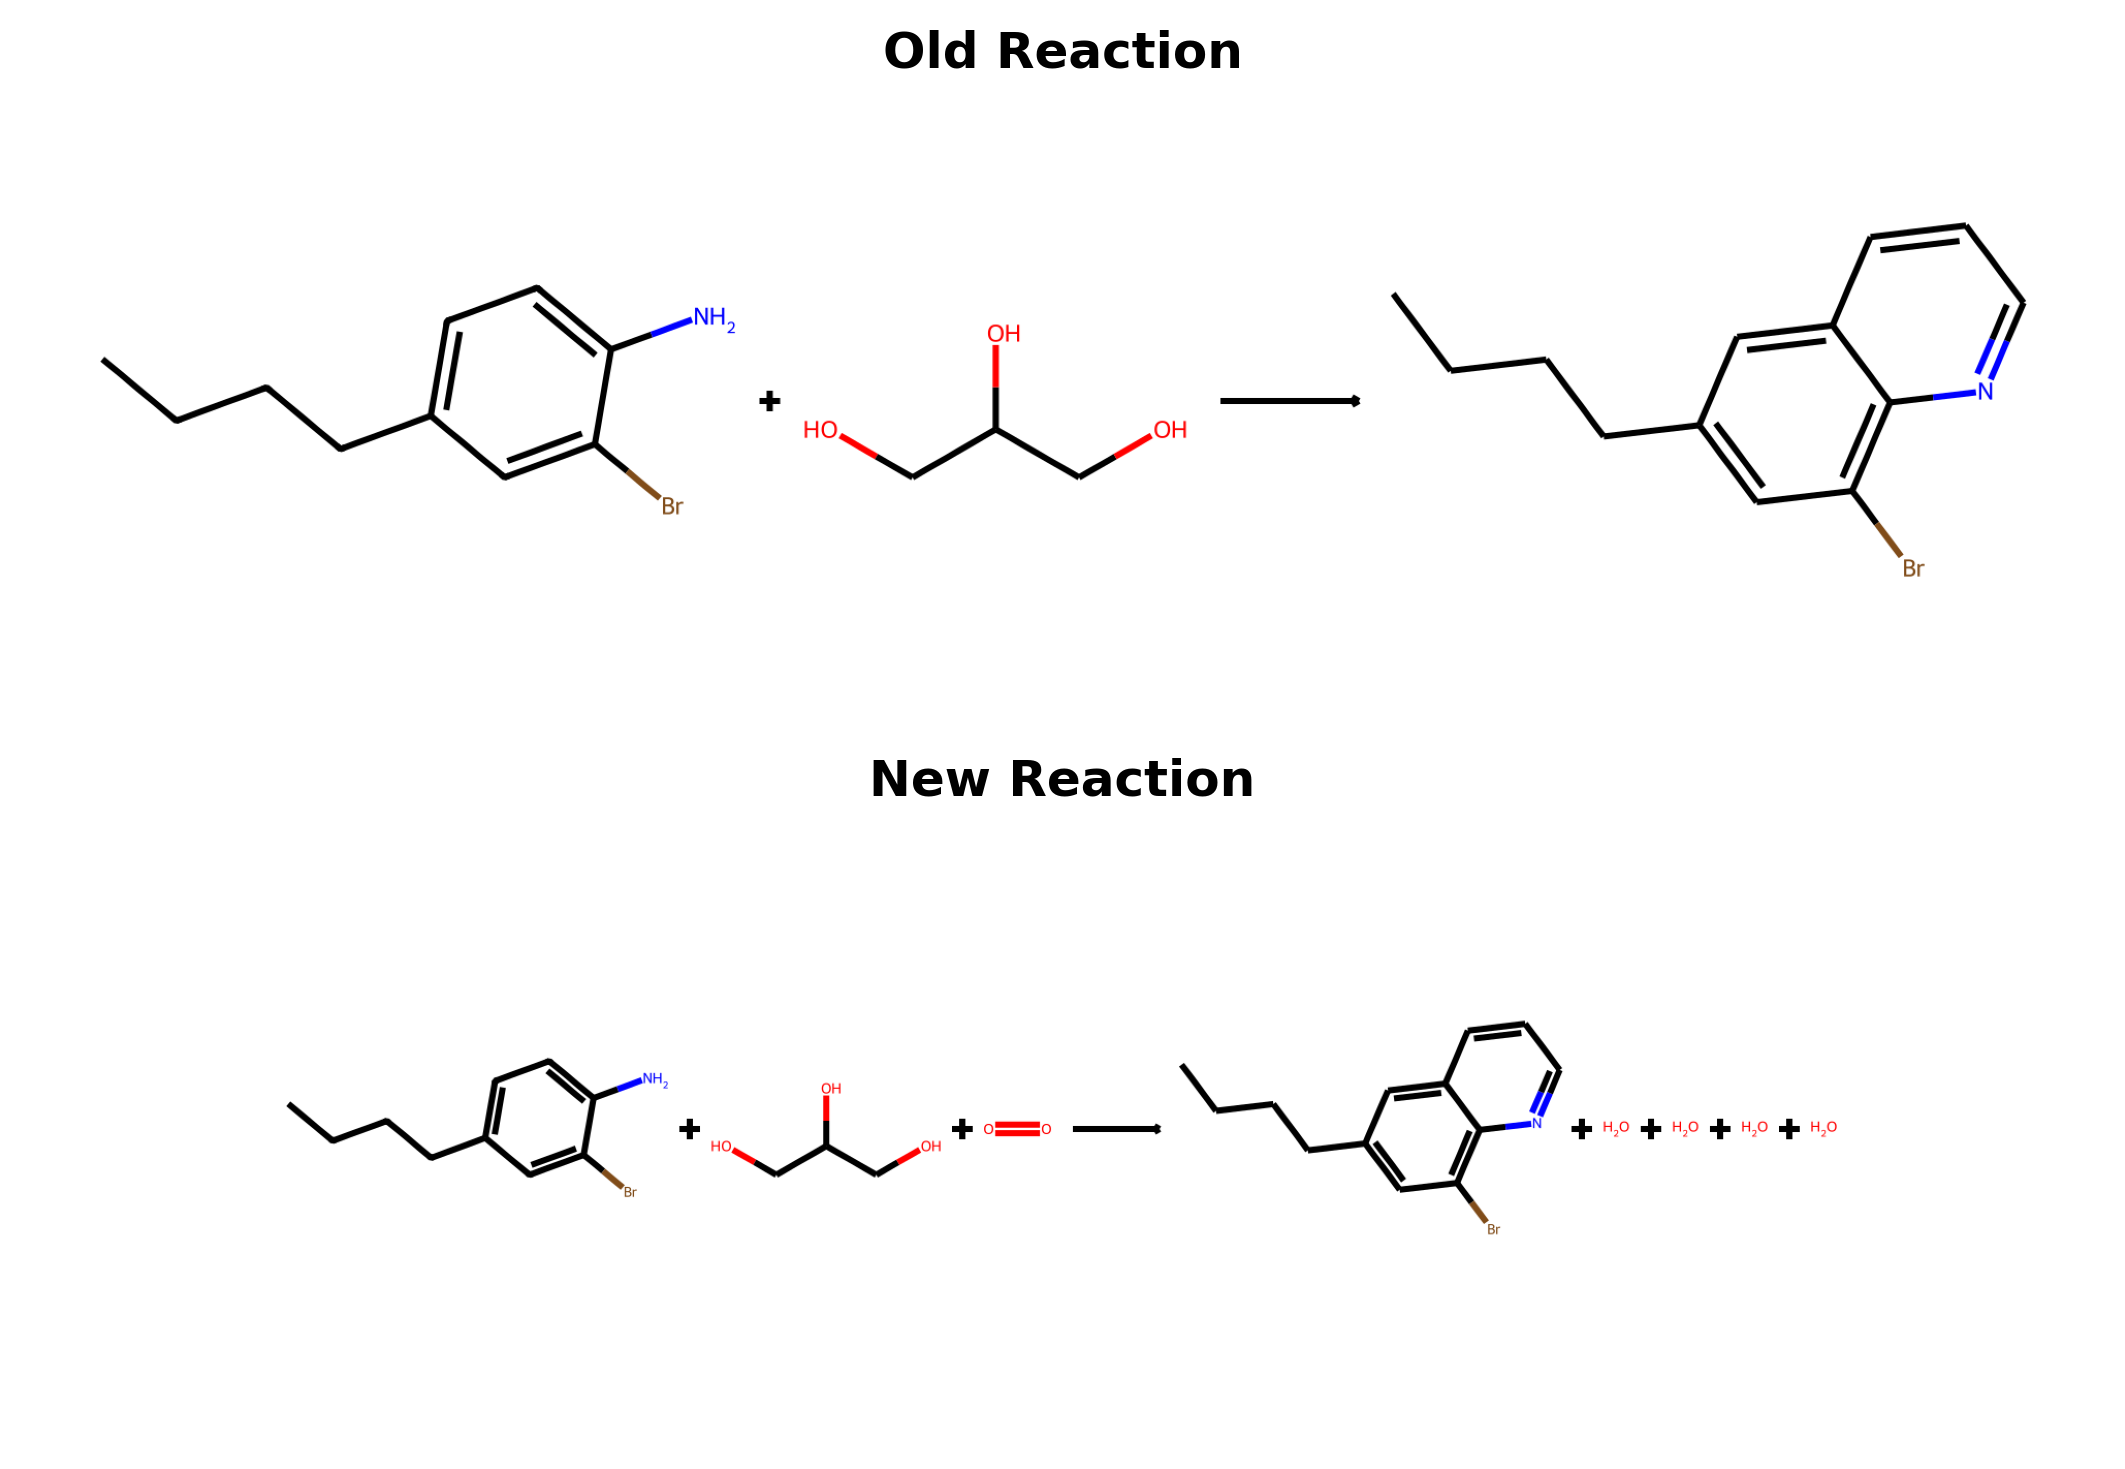

In [239]:
from SynRBL.SynVis.reaction_visualizer import ReactionVisualizer
vis = ReactionVisualizer()
vis.plot_reactions(validate_samples[402], 'reactions', 'new_reaction', show_atom_numbers=False, compare= True, savefig=False, pathname = None, dpi=300)

In [93]:
validate_samples[78]

{'id': 'US20070225340A1',
 'class': 3,
 'reactions': 'CCOC(=O)c1cccc(B(O)O)c1.Cc1cccc(Br)c1I>>CCOC(=O)c1cccc(-c2c(C)cccc2Br)c1',
 'reactants': 'CCOC(=O)c1cccc(B(O)O)c1.Cc1cccc(Br)c1I',
 'products': 'CCOC(=O)c1cccc(-c2c(C)cccc2Br)c1.B(O)(O)I',
 'standardized_reactants': nan,
 'standardized_products': nan,
 'Unbalance': 'Products',
 'Diff_formula': {'O': 2, 'B': 1, 'I': 1, 'H': 2, 'Q': 0},
 'new_reaction': 'CCOC(=O)c1cccc(B(O)O)c1.Cc1cccc(Br)c1I>>CCOC(=O)c1cccc(-c2c(C)cccc2Br)c1.B(O)(O)I'}

In [98]:
def check_carboxyl(smi_comp):
    carboxyl_groups = ["OC(=O)"]
    for group in carboxyl_groups:
        if group in smi_comp:
            return True
    return False

In [99]:
check_carboxyl(validate_samples[78]['products'])

True

In [ ]:
check_carboxyl(smi_comp)

In [44]:
validate_samples[35]

{'id': 'US20110060146A1',
 'class': 7,
 'reactions': 'CCC(CC)(c1ccc(O)c(C)c1)c1ccc(C#CC2(O)CCCC2)c(C)c1>>CCC(CC)(c1ccc(O)c(C)c1)c1ccc(/C=C/C2(O)CCCC2)c(C)c1',
 'reactants': 'CCC(CC)(c1ccc(O)c(C)c1)c1ccc(C#CC2(O)CCCC2)c(C)c1.[HH]',
 'products': 'CCC(CC)(c1ccc(O)c(C)c1)c1ccc(/C=C/C2(O)CCCC2)c(C)c1',
 'standardized_reactants': nan,
 'standardized_products': nan,
 'Unbalance': 'Reactants',
 'Diff_formula': {'H': 2, 'Q': 0},
 'new_reaction': 'CCC(CC)(c1ccc(O)c(C)c1)c1ccc(C#CC2(O)CCCC2)c(C)c1.[HH]>>CCC(CC)(c1ccc(O)c(C)c1)c1ccc(/C=C/C2(O)CCCC2)c(C)c1'}

In [ ]:
for i in range()    

# **4. MCS Rebalancing**

## **4.1. Maximum common substructure**

In [32]:
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import sys
from pathlib import Path
from SynRBL.SynMCS.mcs_missing_graph_analyzer import MCSMissingGraphAnalyzer
from SynRBL.rsmi_utils import load_database, save_database
from rdkit import Chem
import logging


def single_mcs(data_dict, RingMatchesRingOnly=True, CompleteRingsOnly=True, Timeout=60,
               sort='MCS', remove_substructure=True):
    """
    Performs MCS on a single reaction data entry and captures any issues encountered.

    Parameters:
    - data_dict: Dict containing reaction data.
    - params: Optional parameters for MCS analysis.

    Returns:
    - dict: A dictionary containing MCS results and any sorted reactants encountered.
    """

    mcs_results_dict = {'mcs_results': [], 'sorted_reactants': [], 'issue': []}

    try:
        analyzer = MCSMissingGraphAnalyzer()
        mcs_list, sorted_reactants, _ = analyzer.fit(data_dict, RingMatchesRingOnly=RingMatchesRingOnly,
                                                     CompleteRingsOnly=CompleteRingsOnly, sort=sort,
                                                     remove_substructure=remove_substructure, Timeout=Timeout)
        mcs_list_smiles = [Chem.MolToSmiles(mol) for mol in mcs_list]
        sorted_reactants_smiles = [Chem.MolToSmiles(mol) for mol in sorted_reactants]
        mcs_results_dict['mcs_results'] = mcs_list_smiles
        mcs_results_dict['sorted_reactants'] = sorted_reactants_smiles

    except Exception as e:
        mcs_results_dict['issue'] = data_dict
        logging.error(f"Error in single_mcs: {str(e)}")

    return mcs_results_dict

unsolve = load_database('../../Data/Unsolved_reactions.json.gz')
mcs_results_dict = single_mcs(unsolve[0])
mcs_results_dict

{'mcs_results': ['COC(=O)C(CCCCN)NC(=O)NC1:C:C(OC):C:C(C(C)(C)C):C:1O'],
 'sorted_reactants': ['COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O'],
 'issue': []}

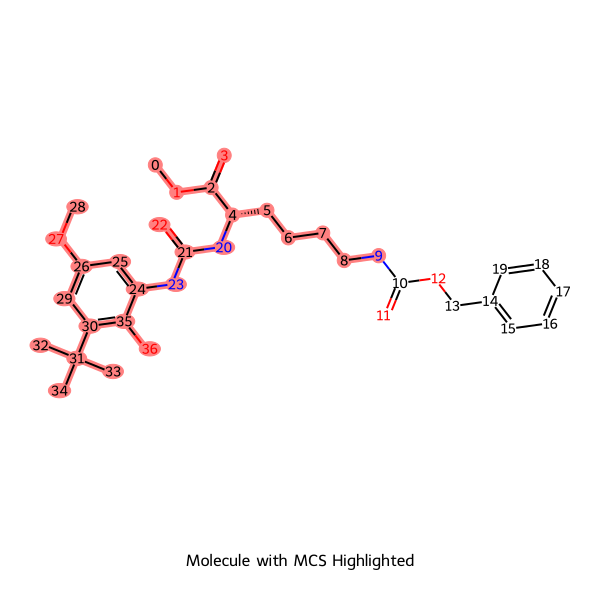

In [33]:
from SynRBL.SynVis.mcs_visualizer import  MCSVisualizer
mcs_vis = MCSVisualizer()
img= mcs_vis.highlight_molecule(mcs_results_dict['sorted_reactants'][0], mcs_results_dict['mcs_results'][0], show_atom_numbers=True, compare=False, missing_graph_smiles=None)
img

## **4.2. Find Graph**

Reactants
Neighbor Atom: [[{'N': 9}]]
Missing compounds in Products
Boundary Atom: [[{'C': 1}]]


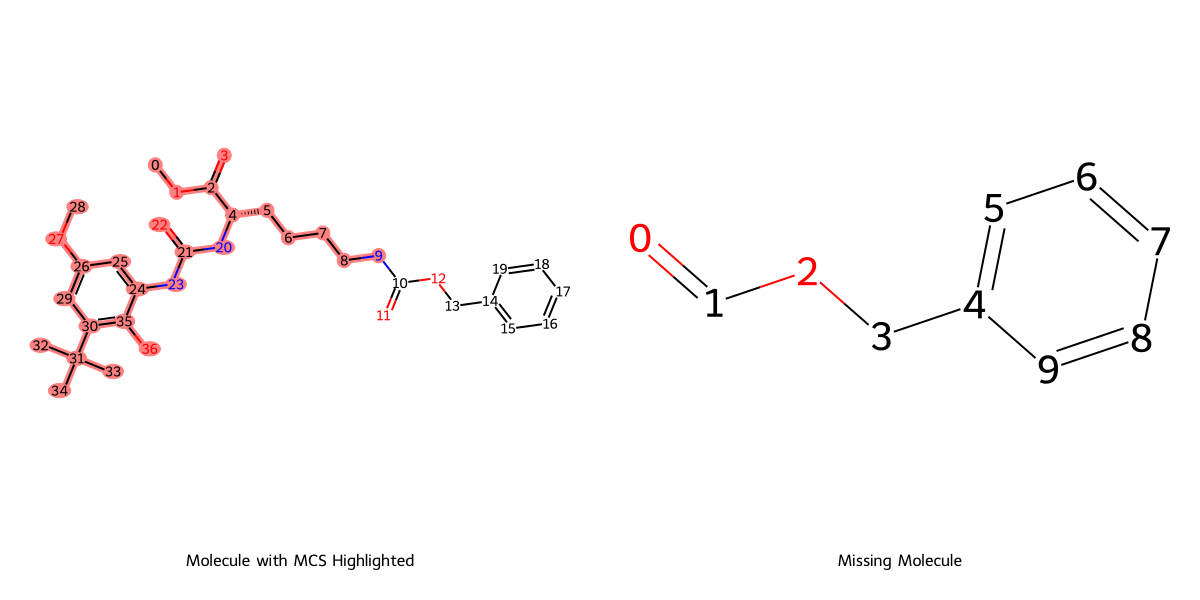

In [44]:
from SynRBL.SynMCS import FindMissingGraphs
from SynRBL.SynVis.mcs_visualizer import  MCSVisualizer
mol_list = [Chem.MolFromSmiles(i) for i in mcs_results_dict['sorted_reactants']]
mcs_list = [Chem.MolFromSmiles(i) for i in mcs_results_dict['mcs_results']]

find_graph = FindMissingGraphs()
missing_graph, boundary, neighbor = find_graph.find_missing_parts_pairs(mol_list=mol_list, mcs_list=mcs_list,use_findMCS=True)




print('Reactants')
print('Neighbor Atom:', neighbor)
print('Missing compounds in Products')
print('Boundary Atom:', boundary)

mcs_vis = MCSVisualizer()
img= mcs_vis.highlight_molecule(mcs_results_dict['sorted_reactants'][0], mcs_results_dict['mcs_results'][0], show_atom_numbers=True, compare=True, missing_graph_smiles=Chem.MolToSmiles(missing_graph[0]))
img


## **4.3. Mol Merge**

## **4.4. Check and Re-Impute by Rule based method**

In [244]:
test = load_database('../../Data/MCS/After_Merge_and_Expansion.json.gz')

In [246]:
pd.DataFrame(test).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17459 entries, 0 to 17458
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            17459 non-null  object
 1   old_reaction  17459 non-null  object
 2   new_reaction  17328 non-null  object
dtypes: object(3)
memory usage: 409.3+ KB


In [252]:
original_data = load_database('../../Data/Unsolved_reactions.json.gz')
len(original_data)

18682

In [255]:
18682-17459

1223

In [254]:
original_2 = load_database('../../Data/MCS/Original_data_Intersection_MCS_3+_matching_ensemble.json.gz')
len(original_2)

17459

In [247]:
original_2 = load_database('../../Data/MCS/Original_data_Intersection_MCS_0_50_largest.json.gz')
len(original_2)

1223

In [248]:
mcs_2 = load_database('../../Data/MCS/Final_Graph_macth_under2-.json.gz')
len(mcs_2)

1217